In [1]:
import bionetgen as pybng
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbrn
from scipy.optimize import minimize
from scipy.stats.distributions import uniform
from sklearn.linear_model import LinearRegression

/home/boltzmann/apps/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Advanced PyBNG usage for analysis

Stuff

### Using an efficient simulator

Stuff and things

In [2]:
# Load model object
model = pybng.bngmodel("SIR.bngl")
# this gets you a libRoadRunner simulator
sim = model.setup_simulator().simulator
# this sets the observable names for the libroadrunner simulator
selections = ["time"] + [obs for obs in model.observables]
sim.timeCourseSelections = selections

BioNetGen version 2.6.0
Reading from file temp.bngl (level 0)
Read 6 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  0.00e+00 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.00 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.00 s.
Finished processing file temp.bngl.
CPU TIME: total 0.01 s.


This allows us to do... 

In [3]:
# Taking a look at original parameter values
for pname in [i for i in model.parameters]:
    print("{} = {:.3g}".format(pname, getattr(sim, pname)))

N = 100
I0 = 1
R0 = 2.5
g = 0.33
b = 0.00825
_InitialConc1 = 99


Quick simulations

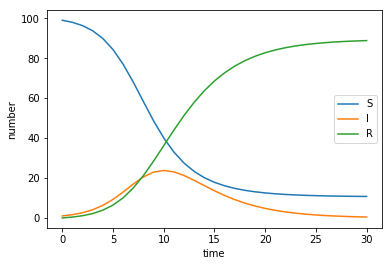

In [4]:
# Run a test simulation and plot
sim.reset()
res = sim.simulate(0, 30, 31)

# we can use the model object again for the observable names
for obs in [obs for obs in model.observables]:
    plt.plot(res['time'],res[obs], label=obs)
plt.xlabel('time')
plt.legend()
_ = plt.ylabel('number')

### Parameter scans

We show cased how to do parameter scans using PyBNG before. However, that involved writing files and therefore wasn't very efficient for work that involves a lot of simulations. 

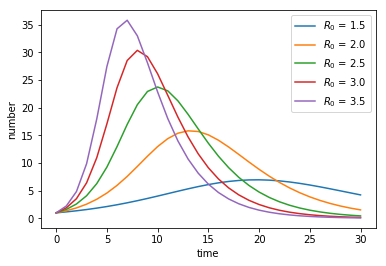

In [5]:
# simple parameter scan
for i in np.arange(1.5,4.0,0.5):
    # set parameter
    sim.R0 = np.float(i)
    # resets all concentrations, forces recalculation of parameters
    sim.reset()
    # simulate
    res = sim.simulate(0, 30, 31)
    # plot infected cell time series
    plt.plot(res['time'], res["I"], label=f"$R_{0}$ = {i}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

### Parameter estimation

Stuff

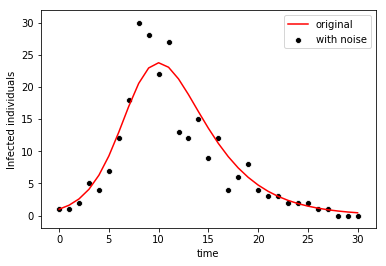

In [6]:
# Run a simulation for data generation
sim.resetAll()
res = sim.simulate(0, 30, 31)

# construct and save synthetic data set for I(t)
m_time = res['time']
m_I = res['I']
# convert infected data to integer and add noise
m_I += np.random.normal(loc=0,scale=0.3*m_I,size=len(m_I))
m_I = np.floor(m_I)
m_I[0] = sim.I0

# convert the data to pandas data frame for later use
d = {'time': m_time, 'I': m_I}
exp = pd.DataFrame(data=d)

# Plot original result and result of adding noise
sbrn.lineplot(x=res["time"], y=res["I"], color="red", label="original")
sbrn.scatterplot(x=exp.time, y=exp.I,color='black', label="with noise")
_ = plt.ylabel('Infected individuals')

We will need a cost function

In [7]:
def cost(params):
    """
    This cost function updates the parameters, 
    runs the model and takes the difference 
    between the model results and the generated data
    """
    sim.R0 = params[0]
    sim.g = params[1]
    sim.reset() # Updates the dependent parameters
    # simulate with the new parameters
    res_c = sim.simulate(0, 30, 31)
    # get the difference between the generated
    # data and the simulated values
    y_diff = exp['I'] - res_c['I']
    # return sum of squares
    return (sum(y_diff**2))

Let's checkout how the cost function works

cost =  6288.126683567734


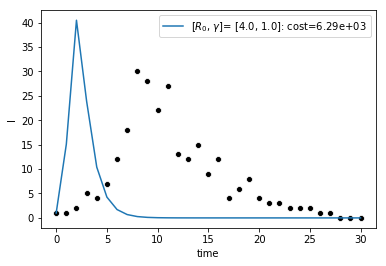

In [8]:
# Show starting cost function value and fit
p0=[4,1]
print("cost = ",cost(p0))
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label=r'[$R_0$, $\gamma$]= [4.0, 1.0]: cost={:0.2e}'.format(cost(p0)))

### Nelder-mead minimization

Is a wonderful method.

In [9]:
# let's run the minimization
minimized = minimize(cost, x0=[10,0.1], method='nelder-mead',options={'maxiter':1000})
print(minimized)

 final_simplex: (array([[2.56244631, 0.34880407],
       [2.56248171, 0.3487885 ],
       [2.56254078, 0.34879618]]), array([235.95961114, 235.95961913, 235.95961933]))
           fun: 235.95961113807604
       message: 'Optimization terminated successfully.'
          nfev: 166
           nit: 87
        status: 0
       success: True
             x: array([2.56244631, 0.34880407])


Let's plot and see how our minimization perfomed

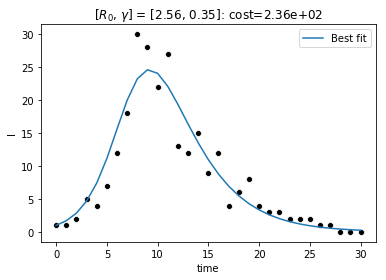

In [10]:
# Show final cost function value and fit
p_final= minimized.x
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

### BFGS minimization

Is also a great method

In [11]:
# run bfgs minimization this time
minimized_bfgs = minimize(cost, x0=[4,1], method='BFGS')
print(minimized_bfgs)

      fun: 235.9596097719339
 hess_inv: array([[ 3.35570530e-10, -5.36541905e-11],
       [-5.36541905e-11,  1.38048724e-11]])
      jac: array([6.86645508e-05, 3.83567810e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 297
      nit: 20
     njev: 95
   status: 2
  success: False
        x: array([2.56247316, 0.34879872])


Let's plot and see how our minimization perfomed

cost =  235.9596097719339
x= [2.56247316 0.34879872]


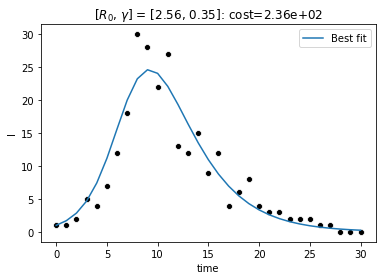

In [12]:
# Show final cost function value and fit
p_final= minimized_bfgs.x
print("cost = ", cost(p_final))
print('x=',p_final)
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(exp.time, exp.I,color='black')
_ = sbrn.lineplot(res['time'], res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

# Simple sensitivity analysis using linear regression 

Let's do a couple parameter scans and see how many recovered cells we are left with

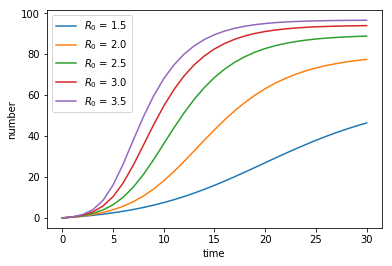

In [13]:
# reset all parameters from previous runs
sim.resetAll()
# simple parameter scan
for i in np.arange(1.5,4.0,0.5):
    sim.R0 = np.float(i)
    sim.reset()
    res = sim.simulate(0,30,31)
    plt.plot(res['time'], res["R"], label=f"$R_{0}$ = {i}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

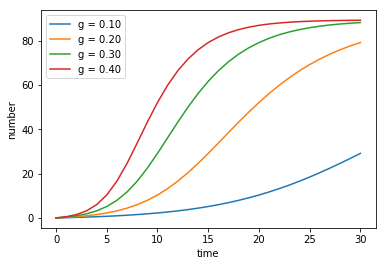

In [14]:
# reset all parameters from previous scan
sim.resetAll()
# simple parameter scan
for i in np.arange(0.1,0.5,0.1):
    sim.g = np.float(i)
    sim.reset()
    res = sim.simulate(0,30,31)
    plt.plot(res['time'], res["R"], label=f"g = {i:.02f}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

Now let's say we wanted to see exactly how R_{0} and g affects the final recovered cell count. 

In [15]:
# import sys
# !{sys.executable} -m pip install pyDOE
import pyDOE

Latin hypercube sampling is great.

In [16]:
sim.resetAll()
# selecting parameters to vary for sensitivity analysis
to_scan = ["R0", "g"]
n_dim = len(to_scan)
# set number of samples
n_samples = int(1e4)
# Getting latin hypercube samples using pyDOE library
lhs_samples = pyDOE.lhs(n_dim, samples=n_samples)
# Get initial parameter values
param_values = [getattr(sim, rate_name) for rate_name in to_scan]
param_values = np.log10(param_values)
# selecting the scale, original value is 1 for an order of magnitude
scale = 1
lhs_samples = uniform(loc=-scale, scale=scale*2.0).ppf(lhs_samples)
# move the center of the distribution to the inital parameter values
for i in range(n_dim):
    lhs_samples[:,i] += param_values[i]
# let's make sure we got the scale right
for i in range(n_dim):
    orig_value = np.float(model.parameters[to_scan[i]].value)
    orig_value = np.log10(orig_value)
    print(f"parameter: {to_scan[i]}, original value: {orig_value}")
    print(f"sample min: {lhs_samples[:,i].min()}, sample max: {lhs_samples[:,i].max()}")

parameter: R0, original value: 0.3979400086720376
sample min: -0.6018874292296942, sample max: 1.3977693059052565
parameter: g, original value: -0.4814860601221125
sample min: -1.4813874841021486, sample max: 0.5183226116526223


We will need to write a simple simulate command and a command to get our observable, final R value.

In [17]:
def simulate_param(simulator, parameters):
    """
    This is to simulate a given set of parameters using the 
    given simulator and return the resulting array. Parameters
    are used assuming they are in log10 space. 
    """
    for pind, pname in enumerate(to_scan):
        simulator.setGlobalParameterByName(pname, np.power(10, parameters[pind]))
    simulator.reset()
    res_c = sim.simulate(0, 30, 31)
    return res_c

def get_obs(result):
    """
    This function takes in the result array and returns
    the observable of interest. In this case it's the final
    recovered cell count. 
    """
    return result["R"][-1]

Let's do our run!

In [18]:
results = []
observables = []
samples = []

for sample in lhs_samples:
    # not all parameter values are possible
    # so we need to account for potential failures here
    try:
        res = simulate_param(sim, sample)
    except RuntimeError:
        continue
    samples.append(sample)
    results.append(res)
    observables.append(get_obs(res))

results = np.array(results)
observables = np.array(observables)
samples = np.array(samples)
print(f"{len(results)} samples successfuly simulated")

10000 samples successfuly simulated


Now we need to do a linear regression

fit score 0.815950270052475
R0 coefficient: 1.1667087376654284, g coefficient: 0.3449966992848952


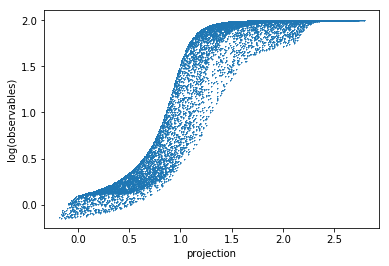

In [19]:
# make sure to remove any negative values
inds_to_use = observables > 0
observables = observables[inds_to_use]
obs = np.log10(observables)
samples = samples[inds_to_use]

# Do the linear regression
reg = LinearRegression().fit(samples,obs)
proj = reg.predict(samples)
score = reg.score(samples, obs)
# Get some information on our fit
print(f"fit score {score}")
print(f"R0 coefficient: {reg.coef_[0]}, g coefficient: {reg.coef_[1]}")

# Plot the observable values versus our predictions
plt.plot(proj, obs, lw=0, marker="+", markersize=1)
plt.ylabel("log(observables)")
_ = plt.xlabel("projection")

Let's see if this worked

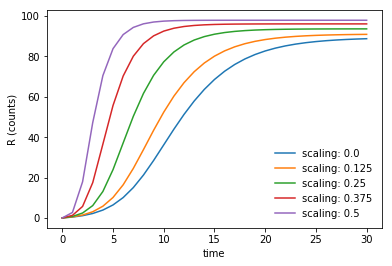

In [20]:
# we want the original parameter values, so let's reset
sim.resetAll()

# we'll change our parameters using our linear regression
# coefficients multiplied by a scaling factor
scaling_obs = []
for lam in np.linspace(0, 0.5, num=5):
    for iparam, pname in enumerate(to_scan):
        # get original value
        cval = sim.getGlobalParameterByName(pname)
        # adjust by scaling factor * coefficient
        sim.setGlobalParameterByName(pname, cval+(lam*reg.coef_[iparam]))
    # reset concentrations, force parameter recalculation
    sim.reset()
    # simulate, get observables, plot
    res = sim.simulate(0,30,31)
    scaling_obs.append(get_obs(res))
    plt.plot(res["time"], res["R"], label=f"scaling: {lam}")
plt.xlabel("time")
plt.ylabel("R (counts)")
_ = plt.legend(frameon=False)

But is it really linear?

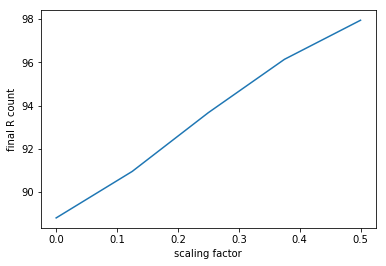

In [21]:
# let's see if the scaling vs observable is actually linear 
plt.plot(np.linspace(0, 0.5, num=5), scaling_obs)
plt.xlabel("scaling factor")
_ = plt.ylabel("final R count")